In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 26 09:15:29 2020

@author: mooselumph
"""

from __future__ import print_function

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn

import torch.optim as optim
import torch.utils.data

#import torchvision.utils as vutils
import numpy as np

from dataset import BasicDataset
from model import Discriminator, Generator, weights_init

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


# Root directory for dataset
nc = 1

# Size of latent space
nz = 100

# Generator
ngf = 64
image_size = 128

# Discriminator
ndf = 64

# Training
batch_size = 10
num_epochs = 5
lr = 0.0002
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dataloader
#dataroot = "/home/raynor/datasets/april/velocity/"
#dataroot = "C:\\Users\\mooselumph\\code\\data\\velocity\\"
dataroot = 'C:/Users/mooselumph/code/data/velocity/'
dataset = BasicDataset(model_dir=dataroot)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Create Generator
netG = Generator(ngpu, nz, ngf, nc).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)


# Create Discriminator
netD = Discriminator(ngpu, nc, ndf).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

Random Seed:  999


In [3]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data['model'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/6]	Loss_D: 0.1030	Loss_G: 6.0146	D(x): 0.9678	D(G(z)): 0.0639 / 0.0028
[1/5][0/6]	Loss_D: 0.0348	Loss_G: 7.3083	D(x): 0.9726	D(G(z)): 0.0064 / 0.0012
[2/5][0/6]	Loss_D: 0.0227	Loss_G: 6.4636	D(x): 0.9846	D(G(z)): 0.0069 / 0.0025
[3/5][0/6]	Loss_D: 0.0321	Loss_G: 7.3753	D(x): 0.9911	D(G(z)): 0.0225 / 0.0009
[4/5][0/6]	Loss_D: 0.0195	Loss_G: 7.3631	D(x): 0.9903	D(G(z)): 0.0096 / 0.0015


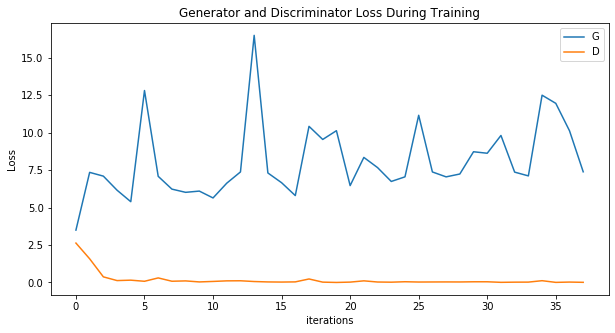

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
%%capture
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)


In [9]:
HTML(ani.to_jshtml())

In [11]:
fake = netG(fixed_noise).detach().cpu()

In [12]:
fake.shape

torch.Size([64, 1, 128, 128])

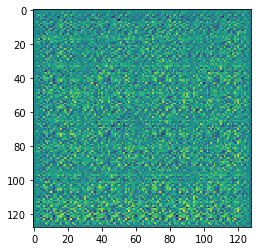

In [15]:
plt.imshow(fake[2,0,:,:].squeeze())